In [50]:
import jupyter
import matplotlib.pyplot as plt
import numpy as np
from numpy import interp
import pandas as pd
from itertools import cycle
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, auc, roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import math
from data import Data


In [51]:
def load_data(file):
    data = []
    with open(file) as f:
        for line in f:
            data.append(line.strip("\n").split(","))
    return data

def decision_tree(data, classLabel):
    arbre = tree.DecisionTreeClassifier(random_state=42)
    return arbre.fit(data, classLabel)




In [52]:
data = Data(load_data("glass.data"))


In [53]:
# explications pour les changements apportés aux données - voir l'annexe pour les diagrammes



In [54]:

# calculs de la moyennes de tous les classificateurs

# moy_arbre= 0.0
# moy_forest=0.0
# moy_baye = 0.0
# moy_knn = 0.0
# for i in range(0,100):
#     train_features, test_features, train_label, test_label= data.splitNormalizedData(0.2)
#     
#     arbre = decision_tree(train_features, train_label)
#     arb_pred = arbre.predict(test_features)
#     moy_arbre += accuracy_score(test_label, arb_pred)
# 
#    forest = RandomForestClassifier()
#     forest.fit(train_features, train_label)
#     f_prediction = forest.predict(test_features)
#     moy_forest += accuracy_score(test_label, f_prediction)
# 
#     gnb = GaussianNB()
#    baye_pred = gnb.fit(train_features, train_label).predict(test_features)
#     moy_baye += accuracy_score(test_label, baye_pred)
# 
#   neigh = KNeighborsClassifier(n_neighbors = round(math.sqrt(train_features.shape[0])/7))
#     neigh.fit(train_features, train_label)
#     knn_pred = neigh.predict(test_features)
#     moy_knn += accuracy_score(test_label, knn_pred)
# 
# print("Moyenne Arbre : %f" % (moy_arbre/100))
# print("Moyenne Forest : %f" % (moy_forest/100))
# print("Moyenne Bayes : %f" % (moy_baye/100))
# print("Moyenne Knn : %f" % (moy_knn/100))

    


    

Arbre de décision : 0.720930 


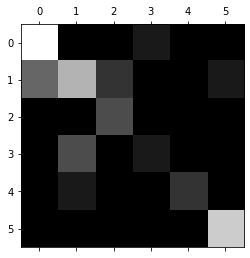

In [55]:
# Arbre de décision et prédiction

train_features, test_features, train_label, test_label= data.splitData(0.2)
arbre = decision_tree(train_features, train_label)

prediction = arbre.predict(test_features)

print("Arbre de décision : %f " % accuracy_score(test_label, prediction))


conf_mx = confusion_matrix(test_label, prediction)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()



Arbre de décision avec <= 10 noeuds : 0.744186 


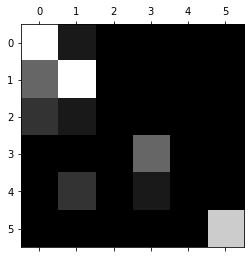

In [56]:
# Arbre de décision avec 10 noeuds et prédiction
path = arbre.cost_complexity_pruning_path(train_features, train_label)
arbre_ccp_alphas, arbre_impurities = path.ccp_alphas, path.impurities

clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=arbre_ccp_alphas[30])
clf.fit(train_features, train_label)

arbre_noeuds_prediction = clf.predict(test_features)

print("Arbre de décision avec <= 10 noeuds : %f " % accuracy_score(test_label, arbre_noeuds_prediction))


conf_mx = confusion_matrix(test_label, arbre_noeuds_prediction)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


In [57]:
names_int = pd.unique(data.data_frame["Type of glass"])
target_names = []
for elem in names_int:
    target_names.append(str(elem))
print(classification_report(test_label, prediction, target_names = target_names, zero_division=0))

              precision    recall  f1-score   support

           1       0.71      0.91      0.80        11
           2       0.64      0.50      0.56        14
           3       0.60      1.00      0.75         3
           5       0.50      0.25      0.33         4
           6       1.00      0.67      0.80         3
           7       0.89      1.00      0.94         8

    accuracy                           0.72        43
   macro avg       0.72      0.72      0.70        43
weighted avg       0.71      0.72      0.70        43



Random Forest : 0.906977 
RI 0.1519645197903918
Na 0.10776966866180553
Mg 0.15903079656331093
Al 0.1583908028927531
Si 0.08844352893483223
K 0.08698552275315787
Ca 0.1251826199126255
Ba 0.07564790889666935
Fe 0.046584631594453724


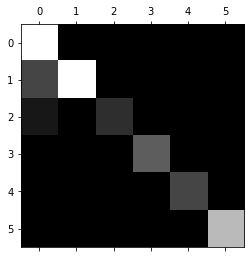

In [58]:
# Test des attributs

forest = RandomForestClassifier()
forest.fit(train_features, train_label)
f_prediction = forest.predict(test_features)
print("Random Forest : %f " % accuracy_score(test_label, f_prediction))
for name, score in zip(data.data_frame[data.getFeatures()], forest.feature_importances_):
    print(name, score)

conf_mx_forest = confusion_matrix(test_label, f_prediction)
plt.matshow(conf_mx_forest, cmap=plt.cm.gray)
plt.show()


Baye naif : 0.558140 


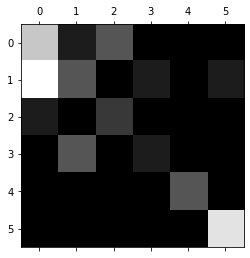

In [59]:

baye = GaussianNB().fit(train_features, train_label)
baye_pred = baye.predict(test_features)
print("Baye naif : %f " % accuracy_score(test_label, baye_pred))

conf_mx_bayes = confusion_matrix(test_label, baye_pred)
plt.matshow(conf_mx_bayes, cmap=plt.cm.gray)
plt.show()

KNN : 0.767442 


e:\Depot_Git\inf5081\inf5081-tp1\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


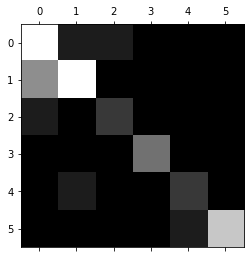

In [60]:

neigh = KNeighborsClassifier(n_neighbors = round(math.sqrt(train_features.shape[0])/7))
neigh.fit(train_features, train_label)
knn_pred = neigh.predict(test_features)

print("KNN : %f " % accuracy_score(test_label, knn_pred))

conf_mx_knn = confusion_matrix(test_label, knn_pred)
plt.matshow(conf_mx_knn, cmap=plt.cm.gray)
plt.show()


In [61]:
# calcul de la courbe de ROC des 4 classificateurs et leurs diagrammes

arbre
clf
forest
baye
neigh

n_classes= 6
X_train, X_test, y_train, y_test = data.splitBinarizedData(0.2)

classifier = OneVsRestClassifier(arbre)
y_score = classifier.fit(X_train, y_train).predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


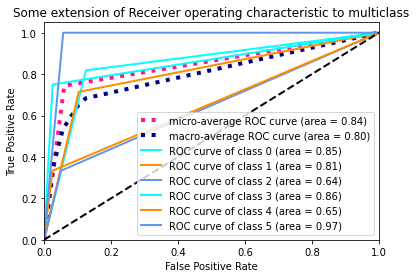

In [62]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw = 2
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [63]:
# '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# ------------------------------------- ANNEXE ------------------------------------------
# .......................................................................................

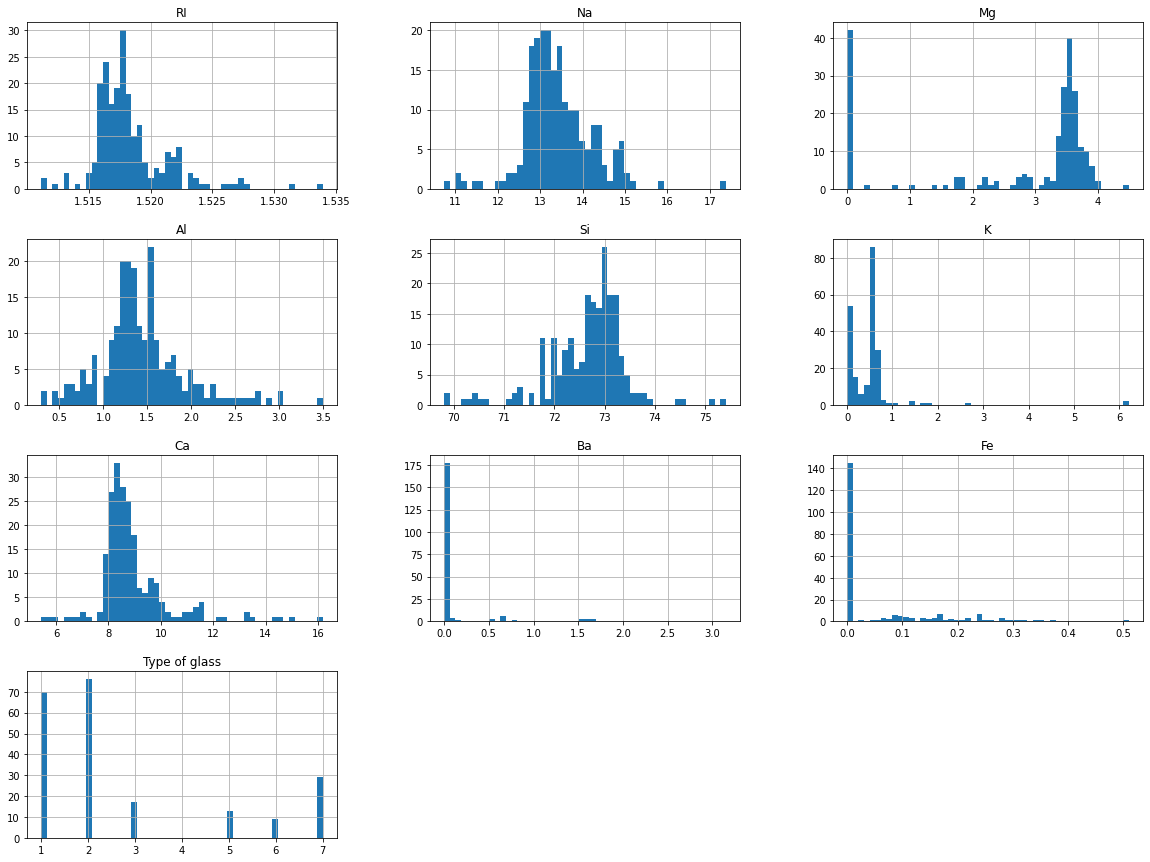

In [64]:
# D1.Histogramme pour toutes les classes 

data.data_frame.hist(bins=50, figsize=(20, 15))
plt.show()

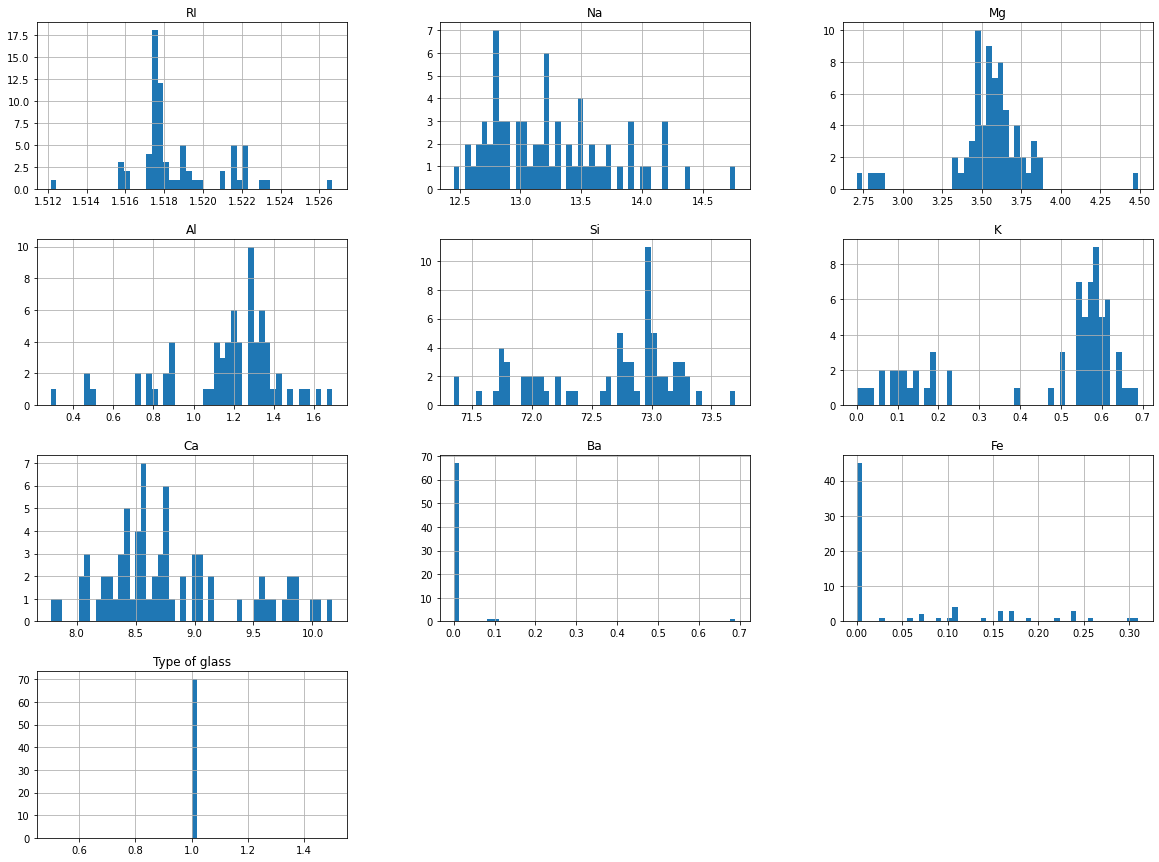

In [65]:
# D2.Histogramme pour la classe 1

data.getClassData(1).hist(bins=50, figsize=(20, 15))
plt.show()

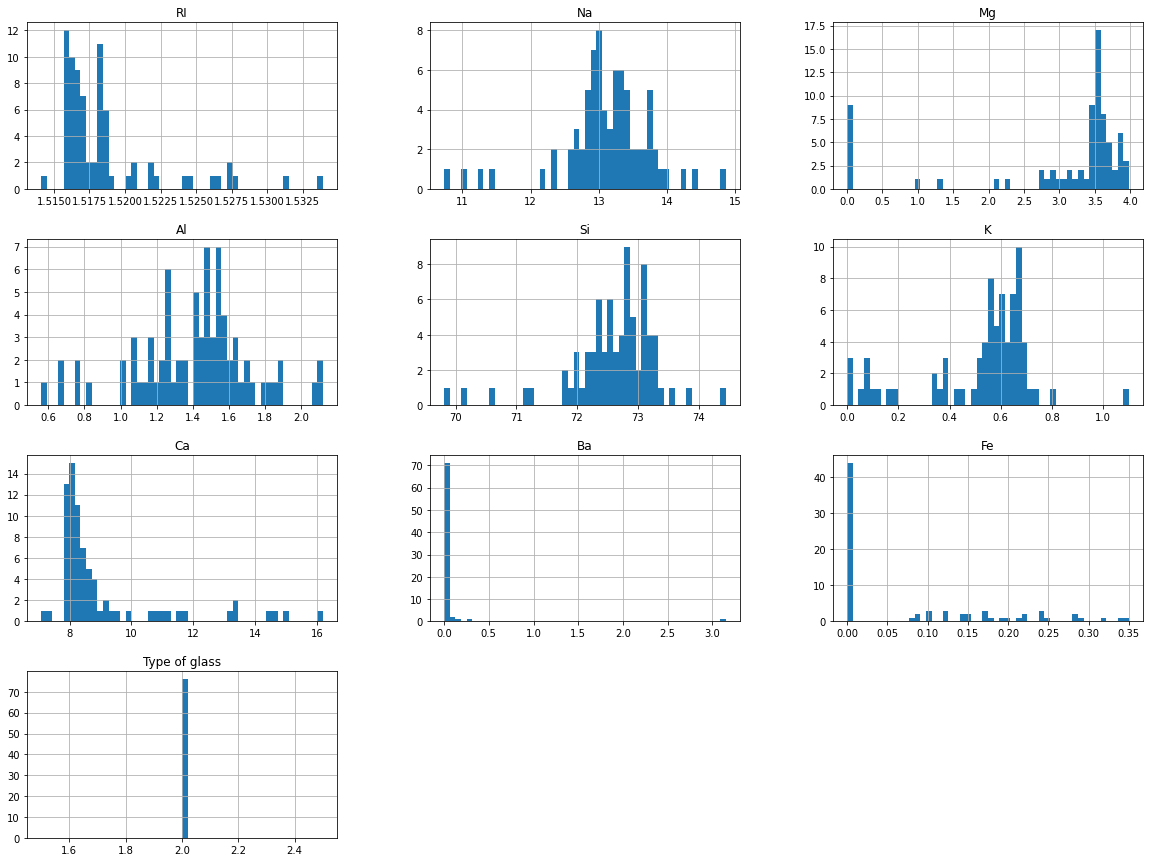

In [66]:
# D3.Histogramme pour la classe 2

data.getClassData(2).hist(bins=50, figsize=(20, 15))
plt.show()

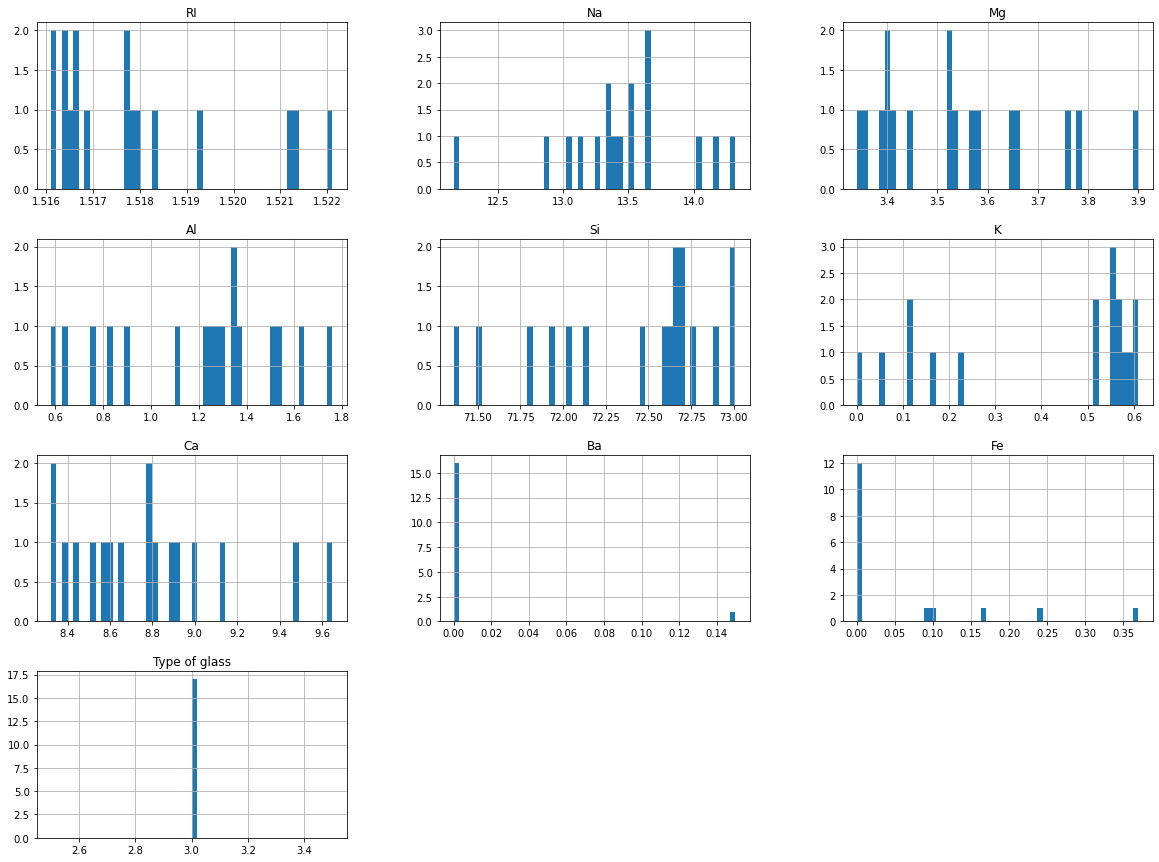

In [67]:
# D4.Histogramme pour la classe 3

data.getClassData(3).hist(bins=50, figsize=(20, 15))
plt.show()

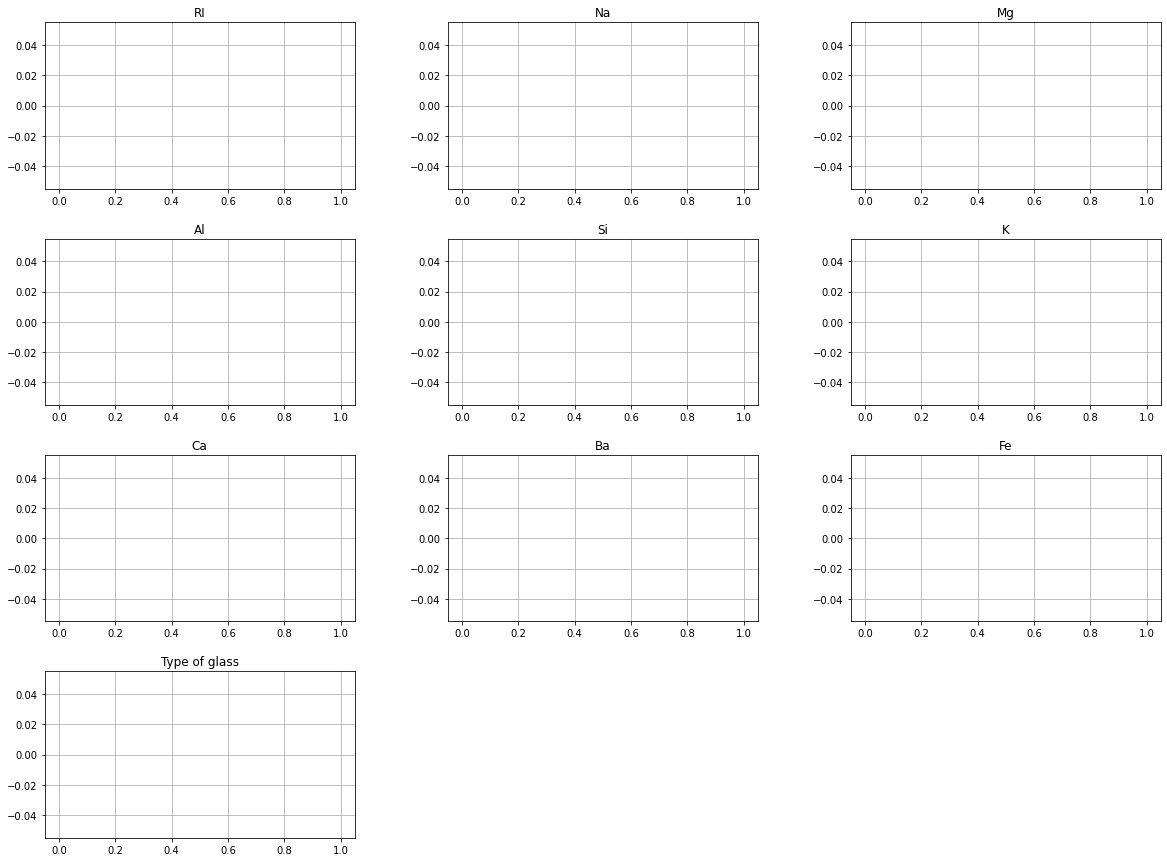

In [68]:
# D5.Histogramme pour la classe 4

data.getClassData(4).hist(bins=50, figsize=(20, 15))
plt.show()

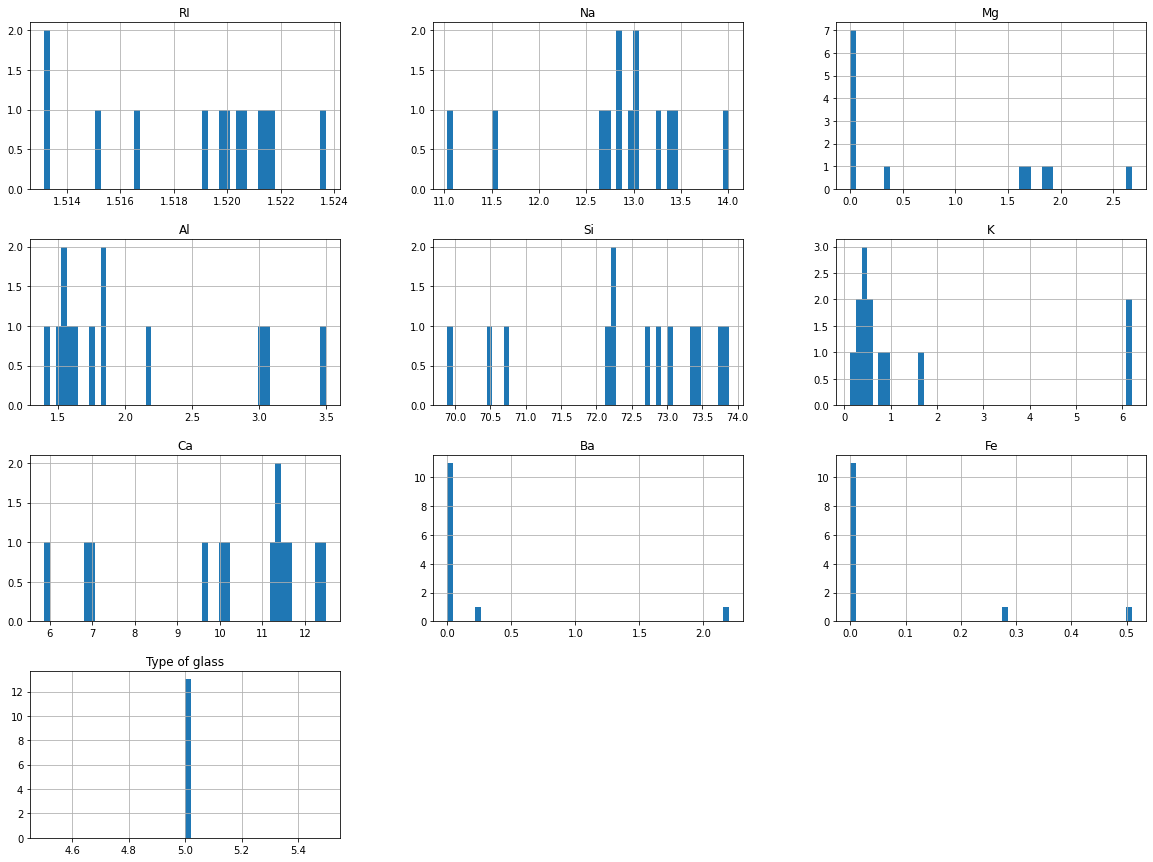

In [69]:
# D6.Histogramme pour la classe 5

data.getClassData(5).hist(bins=50, figsize=(20, 15))
plt.show()

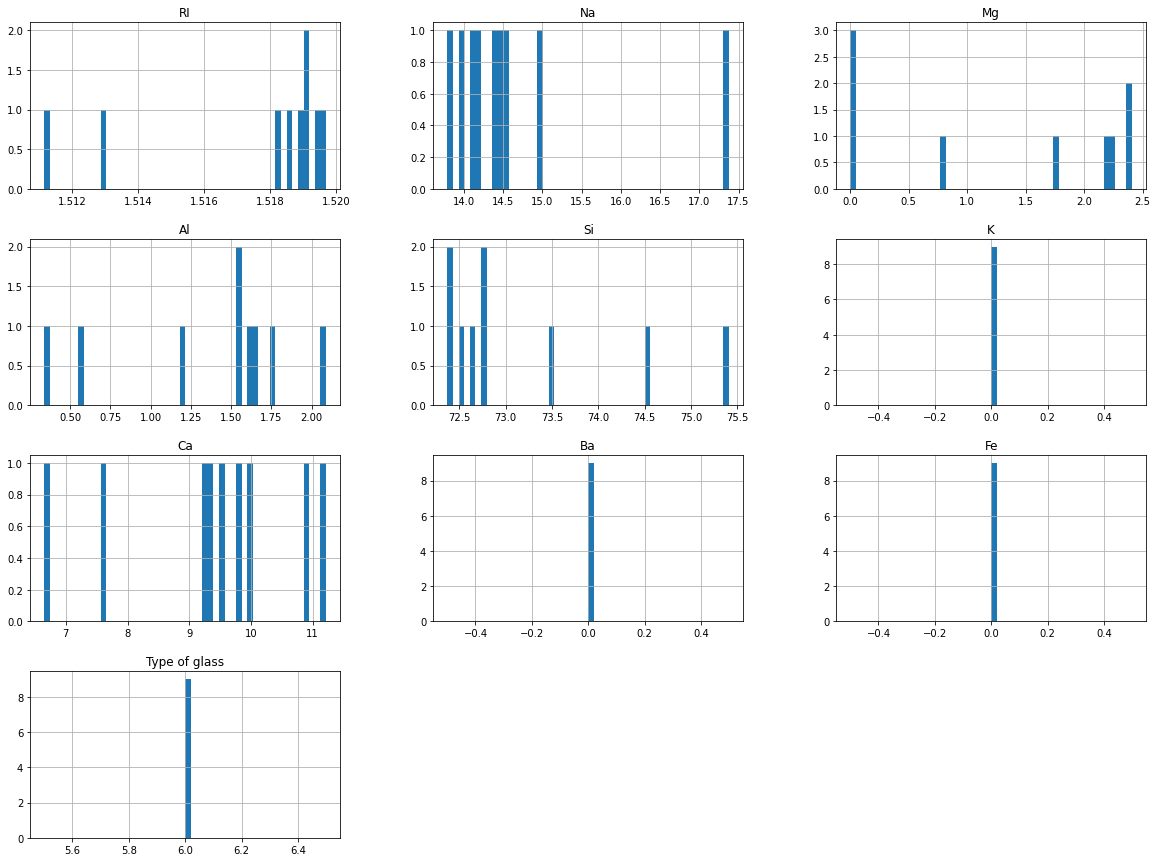

In [70]:
# D7.Histogramme pour la classe 6

data.getClassData(6).hist(bins=50, figsize=(20, 15))
plt.show()

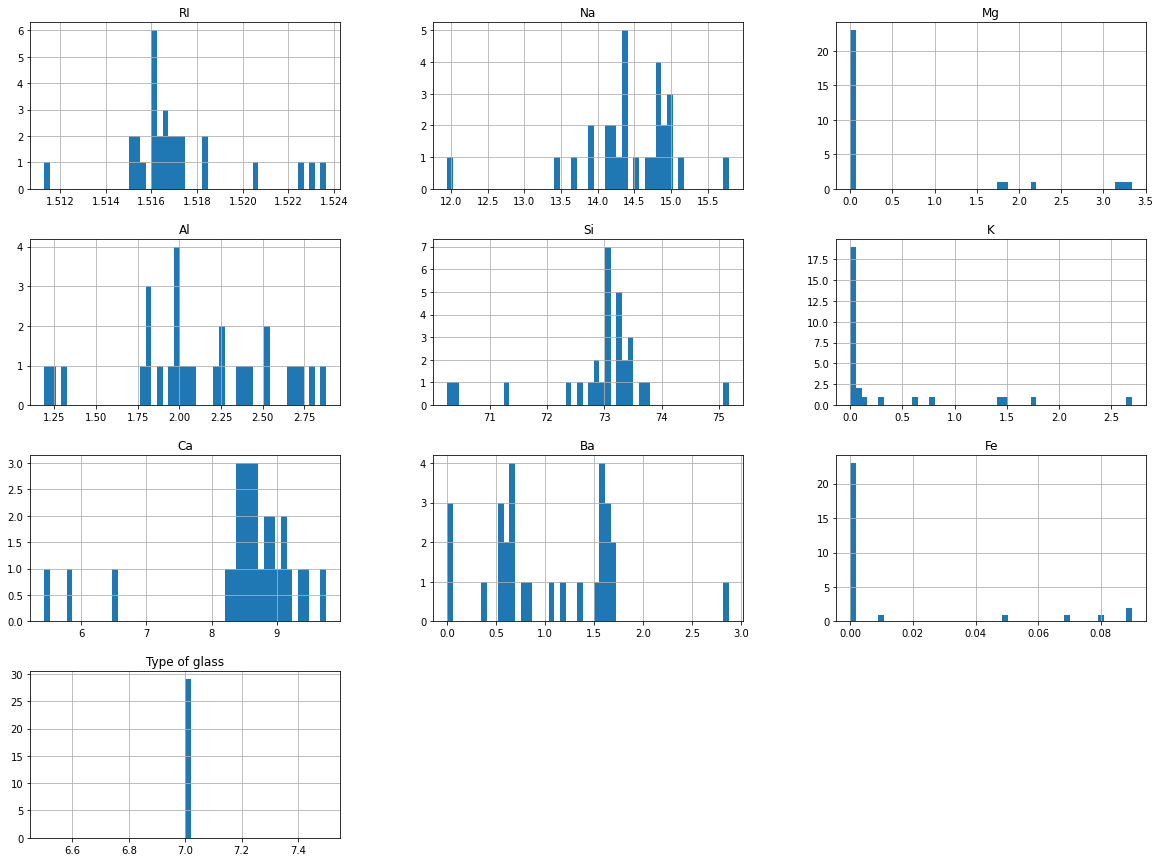

In [71]:
# D8.Histogramme pour la classe 7

data.getClassData(7).hist(bins=50, figsize=(20, 15))
plt.show()

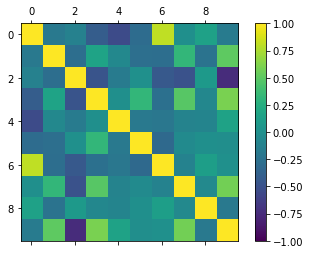

In [72]:
# D9.Matrice de confusion pour toutes les classes

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data.data_frame.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

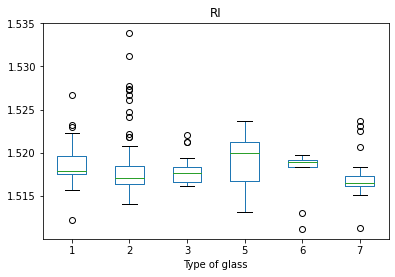

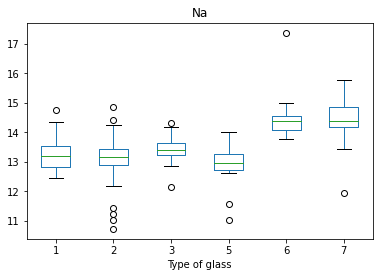

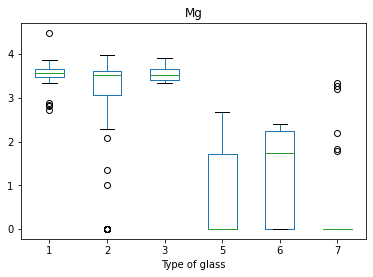

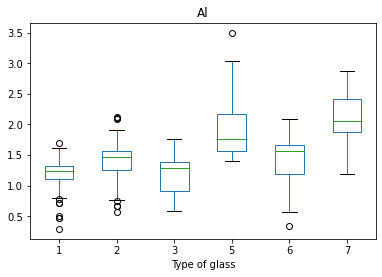

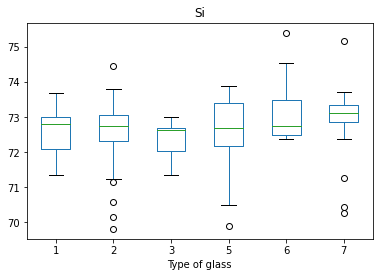

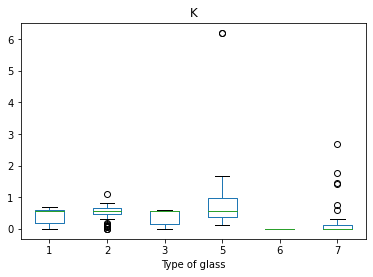

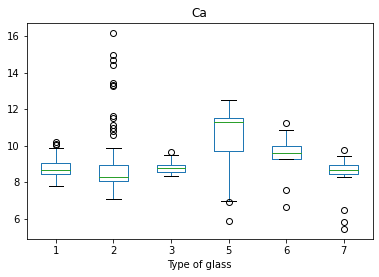

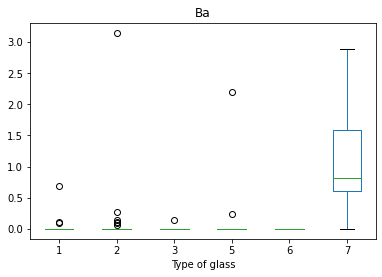

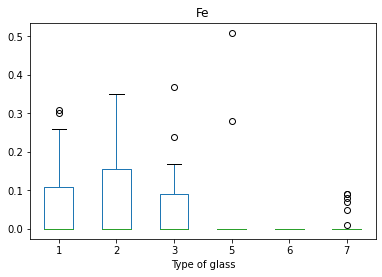

In [73]:
# D10.Diagrammes à moustache pour chaque attribut selon la classe

for column in data.data_frame.columns:
    if column == "Type of glass":
        continue
    data.data_frame.boxplot(column=column, by="Type of glass", grid=False)
    plt.suptitle('')
    plt.show()
    
    del(column)